<a href="https://colab.research.google.com/github/GeoLabUniLaSalle/Python/blob/main/regression_practice1_etu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###TD Regression en domaine non linéaire

Dans ce notebook, nous appliquons différentes méthodes de régression à un problème géophysique réel : le système Lorenz-63. Ce système est dit chaotique, c'est-à-dire que son évolution dépend fortement de la condition initiale. Par conséquent, l'évolution de ce système est difficile à prévoir.
https://fr.wikipedia.org/wiki/Attracteur_de_Lorenz

![L63](https://upload.wikimedia.org/wikipedia/commons/1/13/A_Trajectory_Through_Phase_Space_in_a_Lorenz_Attractor.gif "Lorenz-63")

Ici, à partir d'un ensemble d'observations, l'objectif est tout d'abord d'identifier le système Lorenz-63, c'est-à-dire que nous voulons retrouver les équations du système en utilisant des outils d'apprentissage. Le second objectif est, à partir des modèles identifiés basés sur les données, de générer des trajectoires artificielles du système Lorenz-63.

Cette pratique est largement inspirée de cet article : https://www.pnas.org/content/pnas/113/15/3932.full.pdf.

Commencons par importer les bibliothèques que nous allons utiliser 

Ici matlplotlib et pylab nous permettent de manipuler les données afin de les mettre sous forme de graphique

In [ ]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (26, 12)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### Génération de données

Nous générons des données en suivant le système Lorenz-63 tridimensionnel, également appelé attracteur étrange, donné par :

${\displaystyle {\begin{aligned}{\frac {\mathrm {d} x_1}{\mathrm {d} t}}&=\sigma (x_2-x_1),\\[6pt]{\frac {\mathrm {d} x_2}{\mathrm {d} t}}&=x_1(\rho -x_3)-x_2,\\[6pt]{\frac {\mathrm {d} x_3}{\mathrm {d} t}}&=x_1 x_2-\beta x_3,\end{aligned}}}$

où les paramètres physiques sont $\left(\sigma=10, \rho=28, \beta=8/3\right)$. Nous utilisons des equations de Runge-Kutta 4-5 pour intégrer le modèle, en utilisant la fonction Python *odeint()*. Le temps d'intégration est $\mathrm{d}t=0.001$ et nous générons une séquence de $T=100$ temps de Lorenz.

In [ ]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [ ]:
from scipy.integrate import odeint

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)


### Visualiser les données

Il y a 2 façons de visualiser le système de Lorenz-63. La première consiste à considérer le système comme une série temporelle tridimensionnelle : nous traçons chaque variable en fonction du temps. La seconde est la représentation en espace de phase où nous traçons les relations entre les variables en 3D et nous suivons la trajectoire dans le temps.


** A vous de jouer :**

Proposer une visualisation des différents attracteurs de Lorentz 

Indice le lorentz peut se visualiser en 2D mais pas seulement !
regarder du coté de la documentation de *Axes3D*

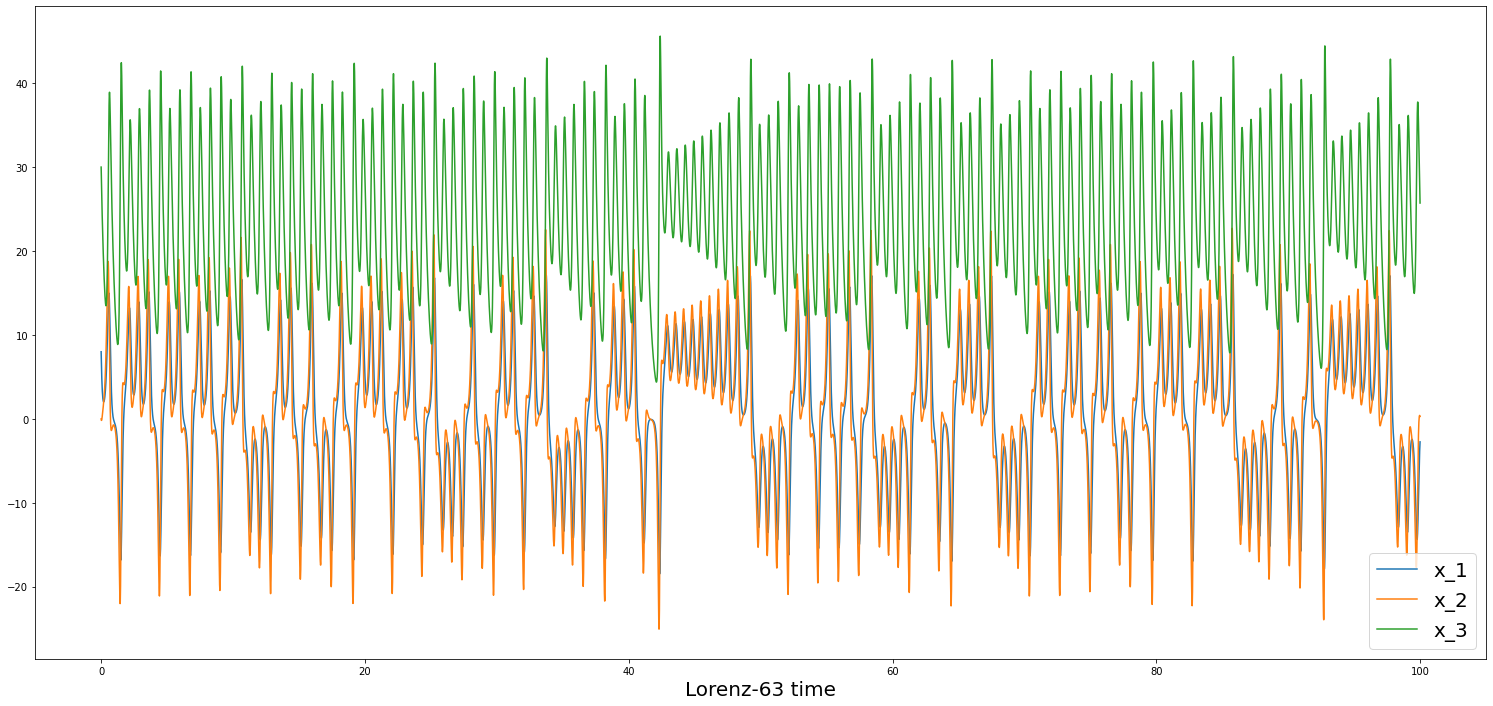

In [ ]:
# time series representation
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x_1','x_2','x_3'], prop={'size': 20})

Text(0.5, 0, '$x_3$')

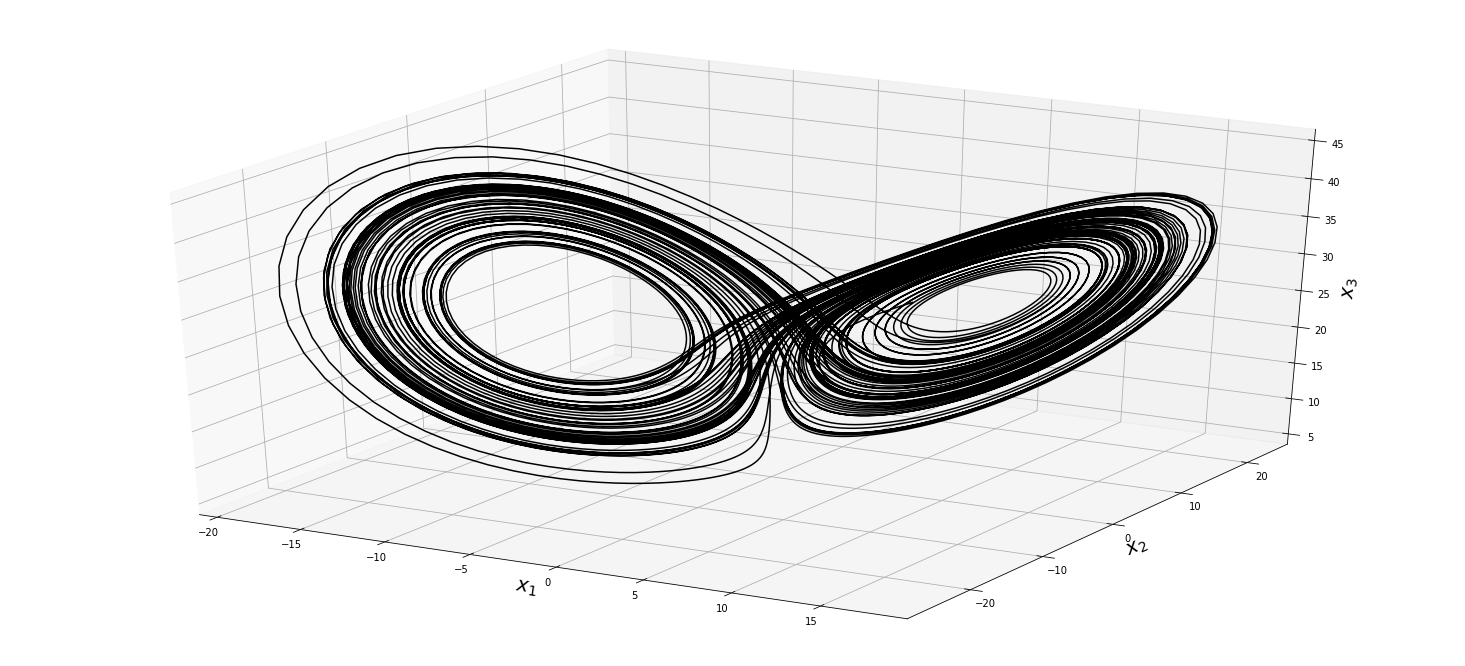

In [ ]:
# phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(x[:,0], x[:,1], x[:,2], 'k')
ax.set_xlabel('$x_1$', size=20);ax.set_ylabel('$x_2$', size=20);ax.set_zlabel('$x_3$', size=20)

### Créer les ensembles de données d'entraînement et de validation

Ici, nous voulons émuler statistiquement le système de Lorenz-63, en utilisant une formulation de régression telle que $Y=f(X)$. Le système de Lorenz-63 est une équation différentielle ordinaire (EDO), où à partir d'une information initiale au temps $t$, les résultats de l'EDO correspondent aux incréments de chaque composant du système entre $t$ et $t+\mathrm{d}t$.

**Questions:**
A partir de la construction d'entrée $X$ et de sortie $Y$ proposées : 

- créer le jeu de données d'apprentissage noté (*X_train*, *Y_train*) correspondant aux premiers 2/3 de la série temporelle
- créer le jeu de données de validation noté (*X_test*, *Y_test*) correspondant à la dernière partie de la série temporelle.

In [ ]:
from numpy.random import normal

# output Y
Y = (x[1:,]-x[:-1,:])/dt

# input X    
X = vstack((x[:-1,0], x[:-1,1], x[:-1,2],\
            x[:-1,0]*x[:-1,0], x[:-1,0]*x[:-1,1], x[:-1,0]*x[:-1,2],\
            x[:-1,1]*x[:-1,1], x[:-1,1]*x[:-1,2], x[:-1,2]*x[:-1,2]\
           )).transpose()

# training set
T_train = int(T/dt*2/3) # size of the training set
#T_train = int(T/dt)
X_train = X[0:T_train,:]
Y_train = Y[0:T_train,:]

# add noise to training data
#X_train = X_train + random.normal(0, 0.5, shape(X_train))
#Y_train = Y_train + random.normal(0, 0.5, shape(Y_train))

# validation set
#X_test = X[:,:]
#Y_test = Y[:,:]

X_test = X[T_train+1:,:]
Y_test = Y[T_train+1:,:]

### Appliquer la régression linéaire multiple

La régression $Y=f(X)$ peut être simplement écrite comme une régression linéaire  telle que : 
\begin{equation}
Y=\sum_{i=1}^p \beta_i X_i.
\end{equation}




**A vous de jouer :**
- Estimez les $(\beta_1, \dots, \beta_p)$ en utilisant les moindres carrés ordinaires
- Comparer les paramètres estimés aux paramètres réels
- A partir des valeurs initiales dans *X_test*, générer les trajectoires prédites en utilisant les régressions linéaires et les comparer aux vraies trajectoires de *Y_test*.

In [ ]:
# import functions

# adjust multiple linear regression (mlr) between X and Y

# print the estimated parameters


In [ ]:
# function to transform the input and output of the regression to a L63 coordinate
def XY_to_L63(X, Y, dt):
    
    L63 = Y*dt + X
    
    # return the L63 coordinate
    return L63

# function to transform a L3 coordinate to the input of the regression, assuming that:
# X = [x1, x2, x3, x1x1, x1x2, x1x3, x2x2, x2x3, x3x3]
def L63_to_X(trajectory):
    
    X = vstack((trajectory[0], trajectory[1], trajectory[2],\
        trajectory[0]*trajectory[0], trajectory[0]*trajectory[1], trajectory[0]*trajectory[2],\
        trajectory[1]*trajectory[1], trajectory[1]*trajectory[2], trajectory[2]*trajectory[2]\
        )).transpose()
    
    # return the X vector
    return X

# apply the linear regressions (only the firt time step is kept into account)


# apply sequentially the linear regressions from the initial value of X_test
traj_true = Y_test*0
traj_mlr = Y_test*0
traj_true[0,:] = XY_to_L63(X_test[0,0:3], Y_test[0,:], dt)
traj_mlr[0,:] = XY_to_L63(X_test[0,0:3], Y_mlr[0,:], dt)
for t in range(1,len(X_test)):
    traj_true[t,:] = XY_to_L63(X_test[t,0:3], Y_test[t,:], dt)
    # apply the linear regressions recursively
    traj_mlr[t,:] = XY_to_L63(traj_mlr[t-1,:], reg_mlr.predict(L63_to_X(traj_mlr[t-1,:])), dt)

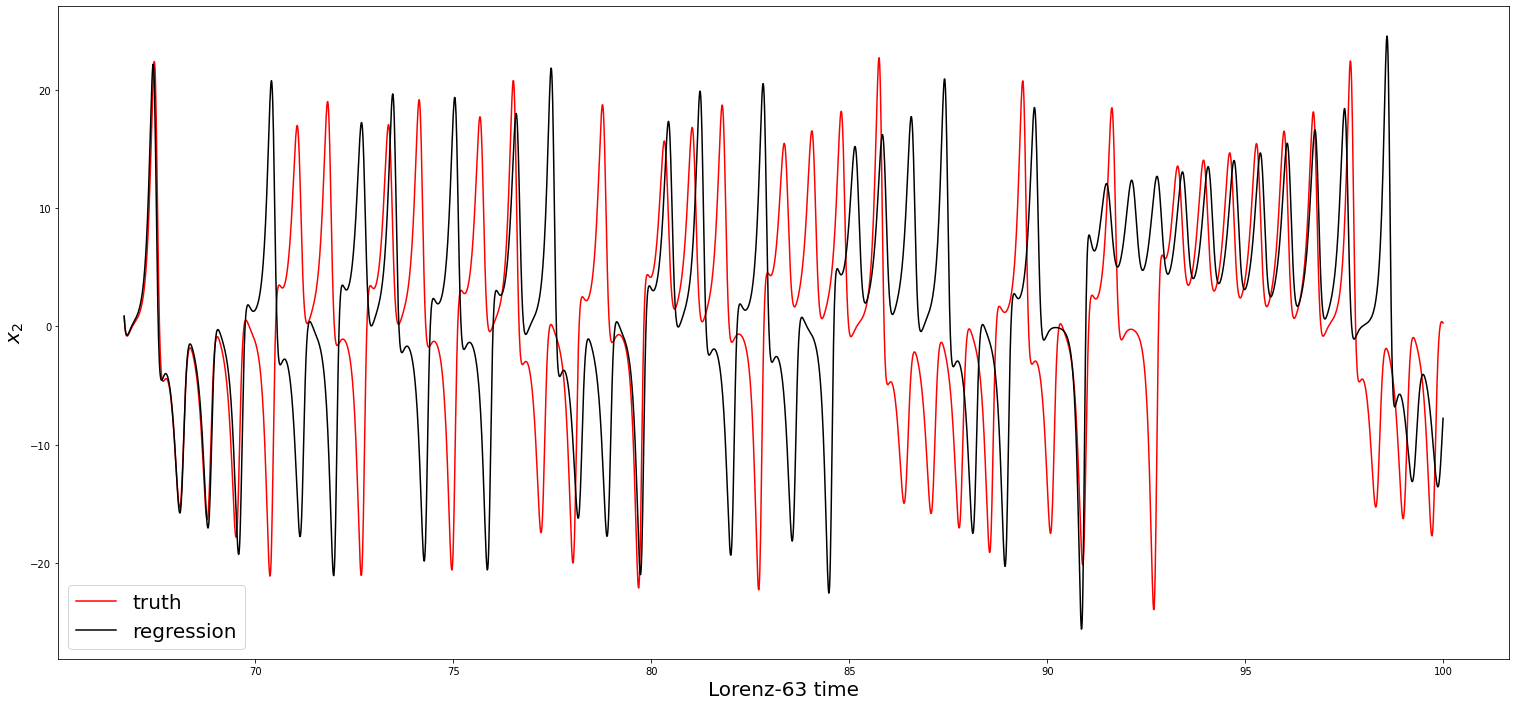

In [ ]:
# time series representation
plot(time[T_train+2:], traj_true[:,1], 'r')
plot(time[T_train+2:], traj_mlr[:,1], 'k')
xlabel('Lorenz-63 time', size=20)
ylabel('$x_2$', size=20)
legend(['truth','regression'], prop={'size': 20})

Text(0.5, 0, '$x_3$')

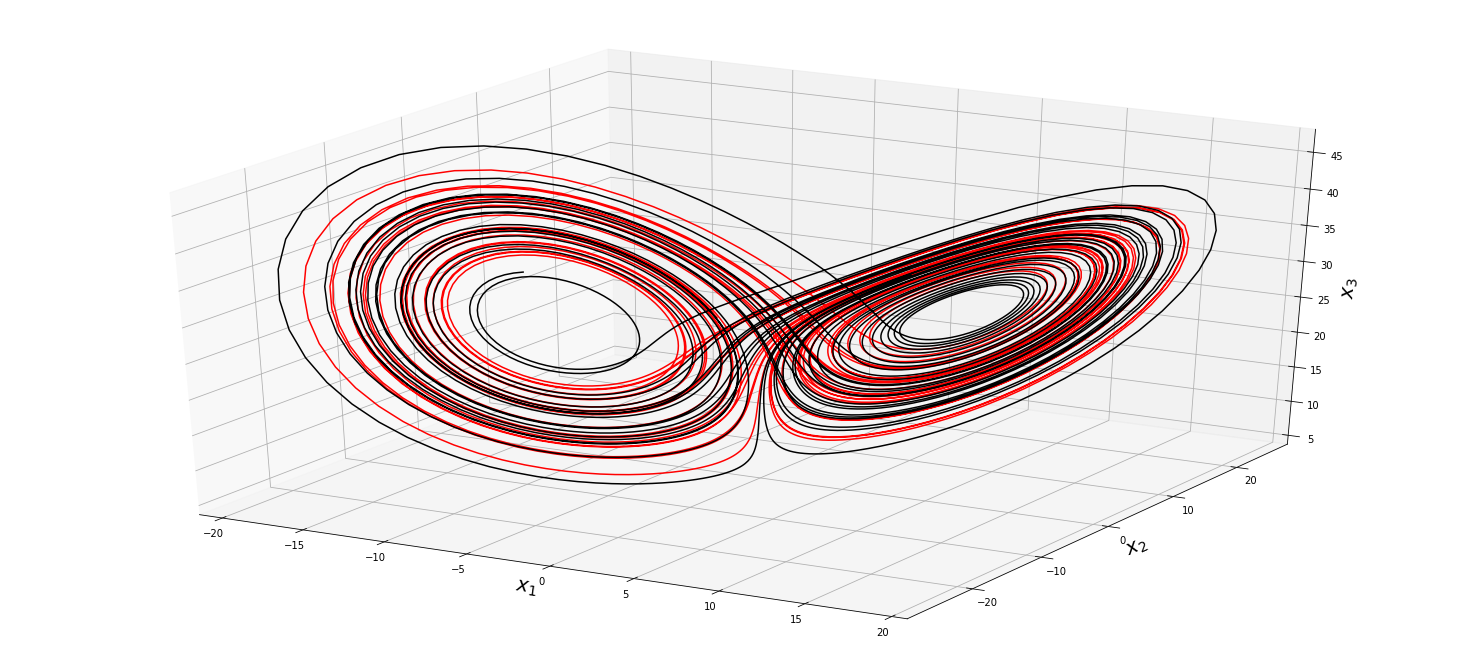

In [ ]:
# phase-space representation
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(traj_true[:,0], traj_true[:,1], traj_true[:,2], 'r')
ax.plot(traj_mlr[:,0], traj_mlr[:,1], traj_mlr[:,2], 'k')
ax.set_xlabel('$x_1$', size=20);ax.set_ylabel('$x_2$', size=20);ax.set_zlabel('$x_3$', size=20)

### Etudier la sensibilité de la régression

Le temps d'intégration actuel du Lorenz-63 est trop court. De plus, le jeu de données d'entraînement est "propre", dans le sens où les observations ne sont pas bruitées. Ainsi, ce problème de régression est relativement facile. Ici, nous proposons d'étudier la sensibilité de la régression aux paramètres clés.

**Questions:**
- Réduire le temps d'intégration à $\mathrm{d}t=0.01$, comparer les modèles identifiés et les trajectoires générées
- générer un jeu de données d'entraînement avec un bruit gaussien additif (moyenne=0, std=0.5), comparer les modèles identifiés et les trajectoires générées.

### Appliquer la régression linéaire locale

Comme vous l'avez vu précédemment, la régression linéaire globale ne permet pas de reproduire des trajectoires réalistes du L63. Nous proposons donc d'appliquer la régression linéaire locale pour améliorer les résultats pour la série x2. Les régressions locales sont construites à partir des plus proches voisins. Ainsi, la taille du jeu de données d'entraînement doit être augmentée (soit totale).

In [ ]:
# adjust local linear regression between x and y


In [ ]:
# time series representation
plot(time[:-1], traj_true[:,1], 'r')
plot(time[:-1], y_llr1, 'k')
xlabel('Lorenz-63 time', size=20)
ylabel('$x_2$', size=20)
legend(['truth','regression'], prop={'size': 20})

Que pouvez vous dire des résultats de l'application ? 